In [42]:
#import python modules

from glob import iglob
from zipfile import ZipFile
import os
import pandas as pd
import numpy as np
import subprocess
import snappy
#import matplotlib.colors as colors
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

#import jpy
from IPython.core.display import display


pd.options.display.max_colwidth = 80

In [43]:
# function to display product preview
def display_product_preview(product, band, min_vv, max_vv, min_vh, max_vh):
    band_data_list = []
    
    for i in band:
        band = product.getBand(i)
        w = band.getRasterWidth()
        h = band.getRasterHeight()
        band_data = np.zeros(w * h, np.float32)
        band.readPixels(0, 0, w, h, band_data)
        band_data.shape = h, w
        band_data_list.append(band_data)
        
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 16))
    ax1.imshow(band_data_list[0], cmap='gray', vmin=min_vv, vmax=max_vv)
    ax1.set_title(output_bands[0])
    ax2.imshow(band_data_list[1], cmap='gray', vmin=min_vh, vmax=max_vh)
    ax2.set_title(output_bands[1])
    
    for ax in fig.get_axes():
        ax.label_outer()

In [44]:
#how to call gpt from command line
#print(subprocess.Popen(['gpt', '-h', 'Subset'], stdout=subprocess.PIPE, universal_newlines=True).communicate()[0])

In [45]:
#read data from source folder
source_path = r'D:\School\Strathclyde\EF_900\Data\SentinelSatData\Rice\S1\prev'
input_S1_files = sorted(list(iglob(os.path.join(source_path, '**', '*S1*.zip'), recursive=True)))
name, sensing_mode, product_type, polarization, height, width, band_names = ([] for i in range(7))

for i in input_S1_files:
    sensing_mode.append(i.split('_')[3])
    product_type.append(i.split('_')[4])
    polarization.append(i.split('_')[-6])
    #read product withh snappy
    s1_read = snappy.ProductIO.readProduct(i)
    name.append(s1_read.getName())
    height.append(s1_read.getSceneRasterHeight())
    width.append(s1_read.getSceneRasterWidth())
    band_names.append(s1_read.getBandNames())
    
df_s1_read = pd.DataFrame({'Name': name, 'Sensing Mode': sensing_mode, 'Product Type': product_type,
                          'Polarization': polarization, 'Height': height, 'Width': width, 'Band Names': band_names})
display(df_s1_read)

,Name,Sensing Mode,Product Type,Polarization,Height,Width,Band Names
0,S1A_IW_GRDH_1SDV_20190614T173730_20190614T173755_027679_031FCA_54F1,GRDH,1SDV,1SDV,16804,25219,"[Amplitude_VH, Intensity_VH, Amplitude_VV, Intensity_VV]"


In [57]:
#display first image
# with ZipFile(input_S1_files[0], 'r') as qck_look:
#     qck_look = qck_look.open(name[0] + '.SAFE/preview/quick-look.png')
#     img = mpimg.imread(qck_look)
#     plt.figure(figsize = (15,15))
#     plt.title('Quick look Visualisation - ' + name[0] + '\n')
#     plt.axis('off')
#     plt.imshow(img)

In [47]:
# 1 create product subset by pixels
x, y, width, height = 2200, 7140, 1300, 1250

parameters = snappy.HashMap()
parameters.put('copyMetadata', True)
parameters.put('region', '%s,%s,%s,%s' % (x, y, width, height))
subset = snappy.GPF.createProduct('subset', parameters, s1_read)
print(list(subset.getBandNames()))


['Amplitude_VH', 'Intensity_VH', 'Amplitude_VV', 'Intensity_VV']


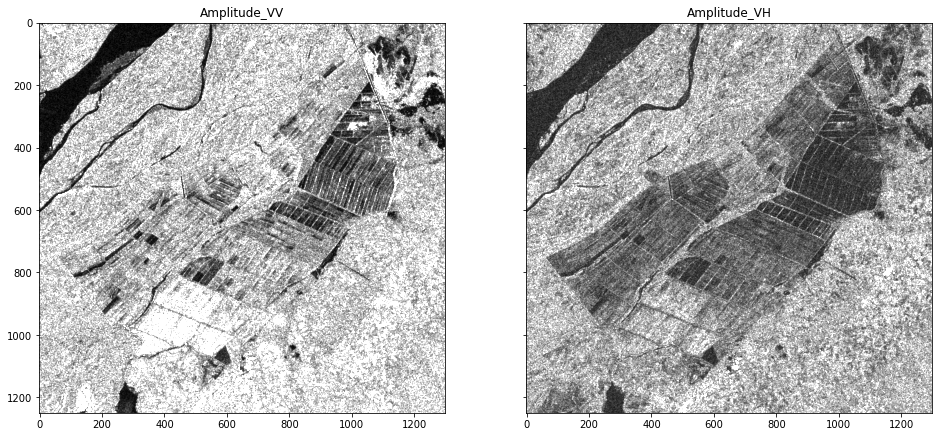

In [48]:
#plot subset for vv and vh
output_bands = ['Amplitude_VV', 'Amplitude_VH']
display_product_preview(subset, output_bands, 41, 286, 20, 160)

In [49]:
# 2 apply orbit file
parameters = snappy.HashMap()
parameters.put('Apply-Orbit-File', True)
apply_orbit = snappy.GPF.createProduct('Apply-Orbit-File', parameters, subset)
print('Orbit updated successfuly')

Orbit updated successfuly


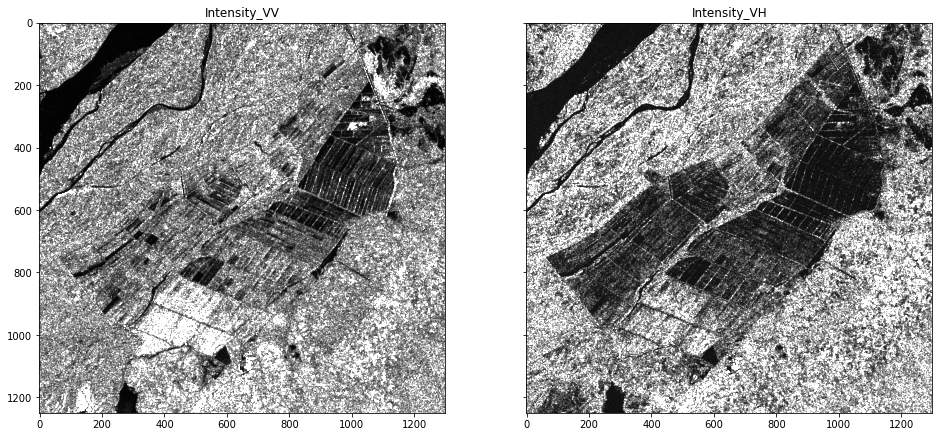

In [50]:
# 3 Remove thermal noise
parameters = snappy.HashMap()
parameters.put('removeThermalNoise', True)
thermal_noise = snappy.GPF.createProduct('ThermalNoiseRemoval', parameters, apply_orbit)

# plot thermal noise removal
output_bands = ['Intensity_VV', 'Intensity_VH']
display_product_preview(thermal_noise, output_bands, 0.02, 99376.52, 0.27, 18471.83)

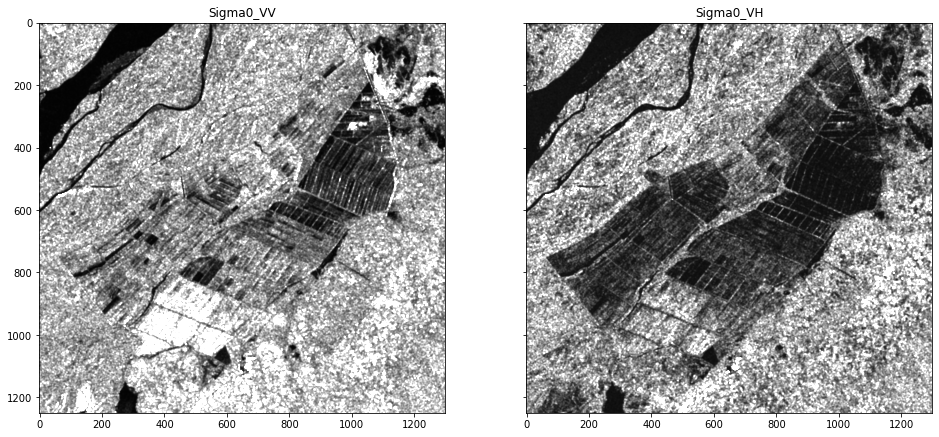

In [53]:
# 4 radiometric calibration
parameters = snappy.HashMap()
parameters.put('outputSigmaBand', True)
parameters.put('sourceBands', 'Intensity_VH,Intensity_VV')
parameters.put('selectedPolarisations', 'VH,VV')
parameters.put('outputImageScaleInDb', False)
calibrated = snappy.GPF.createProduct('Calibration', parameters, thermal_noise)

# display radiometric calibration preview
output_bands = ['Sigma0_VV', 'Sigma0_VH']
display_product_preview(calibrated, output_bands, 0.00, 0.21, 0.00, 0.048)

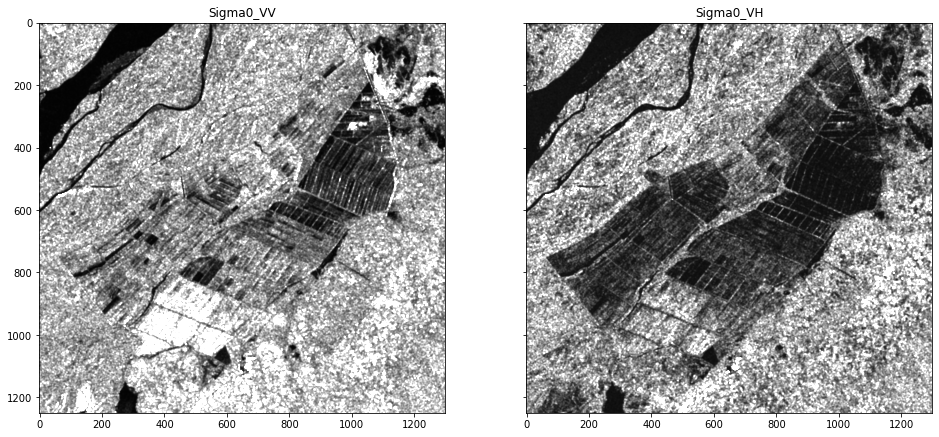

In [54]:
# 5 speckle filtering
parameters = snappy.HashMap()
parameters.put('filter', 'Lee')
parameters.put('filterSizeX', 5)
parameters.put('filterSizeY', 5)
speckle = snappy.GPF.createProduct('Speckle-Filter', parameters, calibrated)

# display speckle filtering preview
output_bands = ['Sigma0_VV', 'Sigma0_VH']
display_product_preview(speckle, output_bands, 0.00, 0.21, 0.00, 0.048)

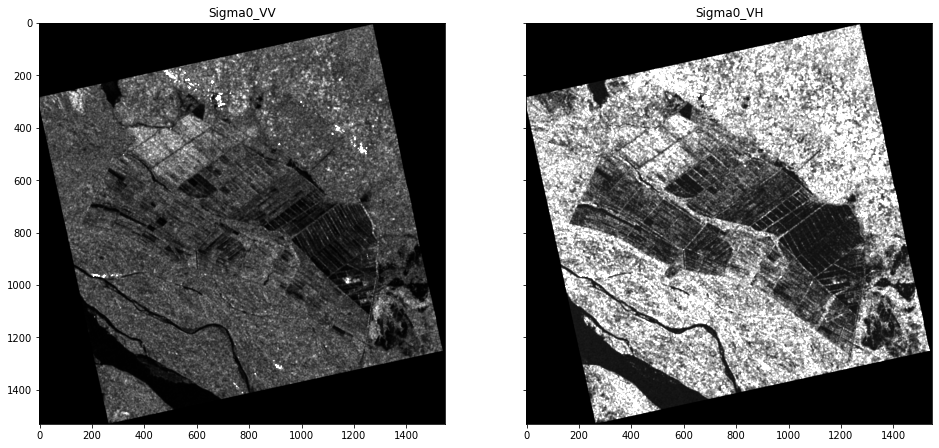

In [55]:
# 6 Terrain correction
proj = ''' PROJCS["UTM Zone / World geodetic System 1984", 
    GEOGCS["World Geodetic System 1984",
        DATUM["World Geodetic System 1984",
            SPHEROID["WGS 84", 6378137.0, 298.257223563, AUTHORITY["EPSG", "7030"]],
            AUTHORITY["EPSG", "6326"]],
        PRIMEM["Greenwich", 0.0, AUTHORITY["EPSG", "8901"]],
        UNIT["degree", 0.017453292519943295],
        AXIS["Geodetic longitude", EAST],
        AXIS["Geodetic latitude", NORTH]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["central_meridian", 3.0],
    PARAMETER["latitude_of_origin", 0.0],
    PARAMETER["scale_factor", 0.9996],
    PARAMETER["false_easting", 500000.0],
    PARAMETER["false_northing", 0.0],
    UNIT["m", 1.0],
    AXIS["Easting", EAST],
    AXIS["Northing", NORTH]]
'''

parameters = snappy.HashMap()
parameters.put('demName', 'SRTM 3Sec')
parameters.put('imgResamplingMethod', 'BILINEAR_INTERPOLATION')
parameters.put('pixelSpacingInMeter', 10.0)
parameters.put('mapProjection', proj)
parameters.put('nodataValueAtSea', False)
parameters.put('saveSelectedSourceBand', True)
terrain_correction = snappy.GPF.createProduct('Terrain-Correction', parameters, speckle)


# display terrain correction preview
output_bands = ['Sigma0_VV', 'Sigma0_VH']
display_product_preview(terrain_correction, output_bands, 0.00, 0.49, 0.00, 0.04)

In [56]:
# write processed product to file
dest_path = r'D:\School\Strathclyde\EF_900\Data\SentinelSatData\Rice\S1\prev\preprocessed'

snappy.ProductIO.writeProduct(terrain_correction, dest_path, 'GeoTIFF')
print(f'Product successfully saved in {dest_path}')

Product successfully saved in D:\School\Strathclyde\EF_900\Data\SentinelSatData\Rice\S1\prev\preprocessed
